# 2022 NZMSA Data Science Submission.

In [106]:
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

import matplotlib.pyplot as plt

%matplotlib inline

# Exploratory Data Analysis.

In [107]:
dataset = pd.read_csv("weather-data.csv")
dataset["valid"] = pd.to_datetime(dataset["valid"])
dataset.head() # Show the first five results.



,station,valid,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
0,NZAA,2015-01-01 00:00:00,21.0,11.0,52.77,15.0,NaN,NaN
1,NZAA,2015-01-01 00:30:00,21.0,10.0,49.37,16.0,NaN,NaN
2,NZAA,2015-01-01 01:00:00,21.0,12.0,56.38,16.0,NaN,NaN
3,NZAA,2015-01-01 01:30:00,21.0,13.0,60.21,16.0,NaN,NaN
4,NZAA,2015-01-01 02:00:00,21.0,12.0,56.38,16.0,NaN,NaN


## Numerical

In [108]:
column = 'tmpc'
#Average
tmpc_avg = dataset[column].mean()
#Standard Deviation
tmpc_stddev = dataset[column].std()
#Percentile range
tmpc_percentiles = dataset[column].quantile([0.1,0.9])
tmpc_percentile_range = abs(tmpc_percentiles[0.9] - tmpc_percentiles[0.1])

print("Temperature")
print(f"\t Average: {tmpc_avg}")
print(f"\t Standard Deviation: {tmpc_stddev}")
print(f"\t Percentile range (10th and 90th): {tmpc_percentile_range}")

Temperature
	 Average: 15.81150292251008
	 Standard Deviation: 4.235196864334063
	 Percentile range (10th and 90th): 10.0


In [109]:
dataset.describe()

,tmpc,dwpc,relh,sknt,gust,peak_wind_drct
count,103678.000000,103678.000000,103593.000000,103704.000000,1203.000000,0.0
mean,15.811503,12.115772,79.782307,8.919029,30.962594,NaN
std,4.235197,3.738005,12.562199,5.348379,6.319510,NaN
min,2.000000,-2.000000,29.230000,0.000000,13.000000,NaN
25%,13.000000,9.000000,71.450000,5.000000,27.000000,NaN
50%,16.000000,12.000000,81.990000,8.000000,31.000000,NaN
75%,19.000000,15.000000,88.180000,12.000000,35.000000,NaN
max,29.000000,23.000000,100.000000,42.000000,56.000000,NaN


## Graphical

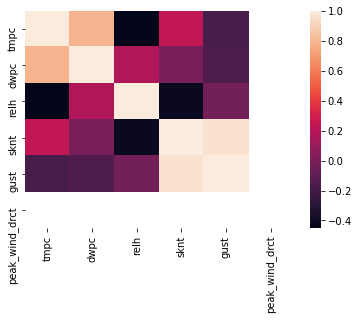

In [110]:
# Correlation plot
corr = dataset.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)


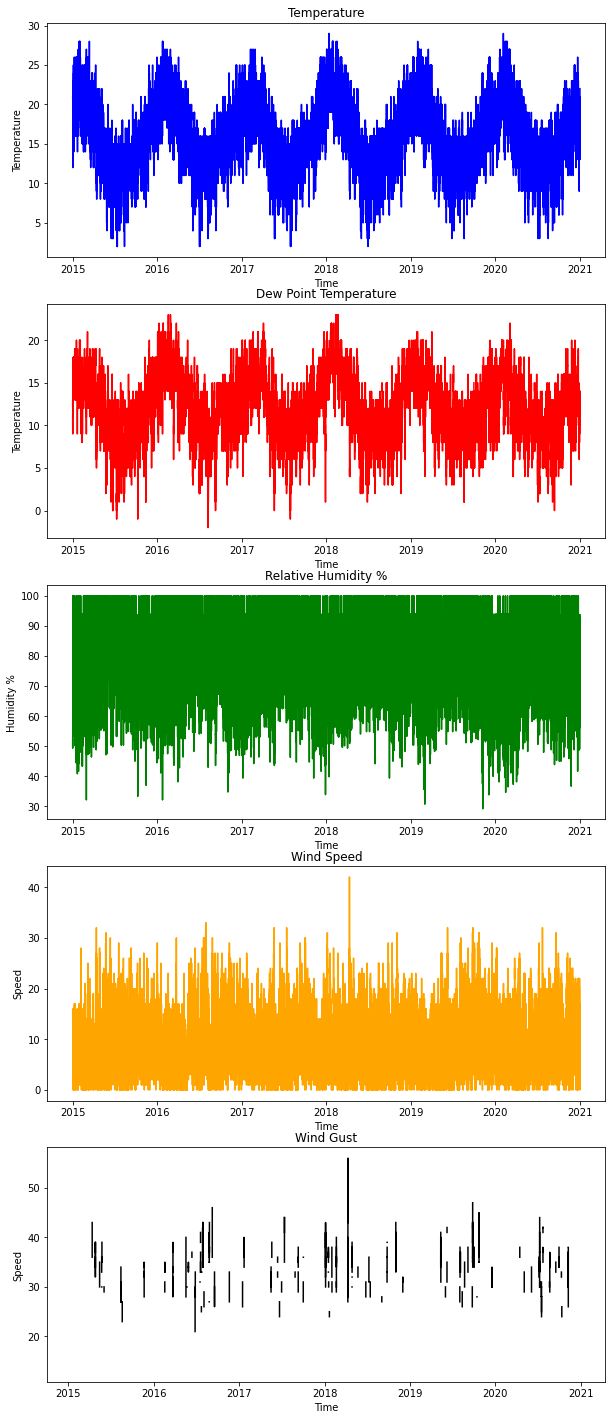

In [111]:
#Graph values
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, squeeze=True)

ax1.plot(dataset["valid"], dataset["tmpc"], color="blue")
ax1.set_title("Temperature")
ax1.set_xlabel("Time")
ax1.set_ylabel("Temperature")

ax2.plot(dataset["valid"], dataset["dwpc"], color="red")
ax2.set_title("Dew Point Temperature")
ax2.set_xlabel("Time")
ax2.set_ylabel("Temperature")

ax3.plot(dataset["valid"], dataset["relh"], color="green")
ax3.set_title("Relative Humidity %")
ax3.set_xlabel("Time")
ax3.set_ylabel("Humidity %")

ax4.plot(dataset["valid"], dataset["sknt"], color="orange")
ax4.set_title("Wind Speed")
ax4.set_xlabel("Time")
ax4.set_ylabel("Speed")

ax5.plot(dataset["valid"], dataset["gust"], color="black")
ax5.set_title("Wind Gust")
ax5.set_xlabel("Time")
ax5.set_ylabel("Speed")

    
    

    
    
fig.set_size_inches(10,25)
plt.show()
    

## Comment on Dataset
The dataset provides a variety of data points from 2015-2021. From the temperature graph a clear pattern is visible. We are able to see the seasonal weather change from summer to winter - with a 1 year period. Therefore
we might just want to look at the day of the year, rather than the year itself to get a higher overall accuracy.

Furthermore it is clear than the Wind Gust data is incomplete and sparse.

# Data Processing

In [112]:
USE_ORDINAL = False

In [113]:
from sklearn.model_selection import train_test_split

#Drop uncessary columns
dataset.drop(columns=["peak_wind_drct", "gust"], inplace=True)

#Drop any row with not defined
dataset = dataset.dropna()

if USE_ORDINAL:
    #Regression model requires datetime column to be in ordinal format
    dataset["valid"] = dataset["valid"].apply(datetime.toordinal)
else:
    #In terms of processing date regression model prefer an ordinal format. Or because we identifed a yearly cycle in temperature, we can ignore the year
    dataset["valid"] = dataset["valid"].dt.dayofyear


time_train, time_test, tmpc_train, tmpc_test = train_test_split(dataset[["valid"]], dataset["tmpc"], test_size=0.2)




2020-12-30 23:30:00


# Data Modelling

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

model = LinearRegression()
model.fit(time_train, tmpc_train)

tmpc_pred = model.predict(time_test)
df= pd.DataFrame({'Actual': tmpc_test[:20], 'Predicted': tmpc_pred[:20]})
print(df)



        Actual  Predicted
30521     20.0  15.938974
13643     16.0  16.042453
53805     18.0  15.798722
65304     15.0  15.730306
58478     14.0  15.770785
25838     11.0  15.968051
17582     19.0  16.018508
94898     13.0  15.554135
59961     15.0  15.761948
53581     22.0  15.800147
91699     16.0  15.573234
33526     16.0  15.921015
71607     17.0  15.692677
95606     13.0  15.550144
66992     22.0  15.720043
66108     17.0  15.725460
60973      9.0  15.755962
28950     14.0  15.948666
101555    22.0  15.514511
40835     15.0  15.876260


In [115]:
score = model.score(time_test, tmpc_test)
print(score)

0.0021086501556591974


In [116]:
if USE_ORDINAL:
    start_date = datetime.fromordinal(dataset["valid"].max()) + timedelta(days=1)
    end_date = start_date + timedelta(weeks=1)

    date_range = pd.DataFrame({'date': pd.date_range(start=start_date, end=end_date, periods=7)})
    date_range_nonordinal = date_range.copy()
    date_range['date'] = date_range['date'].apply(datetime.toordinal)
    date_range_df = date_range['date'].to_frame()

    forcast_pred = model.predict(date_range_df)

    print("Next weeks forcast")
    print(f"{start_date} - {end_date}")
    print("==============================")
    preds= pd.DataFrame({'Date': date_range_nonordinal['date'], 'Predicted': forcast_pred})
    print(preds)


else:
    import numpy as np
    start_date = dataset["valid"].max() + 1
    date_range = np.arange(start_date, start_date+8, step=1)
    date_range = date_range % 365
    
    #Reshape to two-dimensional array (n, 1)
    date_range = date_range.reshape(-1, 1)

    forcast_pred = model.predict(date_range)

    print("Next weeks forcast")
    print("==============================")
    print("Day Forcast")
    for day, forcast in zip(date_range, forcast_pred):
        print(f"{day} {forcast}")



Next weeks forcast
2020-12-31 00:00:00 - 2021-01-07 00:00:00
                 Date  Predicted
0 2020-12-31 00:00:00  15.501683
1 2021-01-01 04:00:00  15.501398
2 2021-01-02 08:00:00  15.501113
3 2021-01-03 12:00:00  15.500828
4 2021-01-04 16:00:00  15.500543
5 2021-01-05 20:00:00  15.500257
6 2021-01-07 00:00:00  15.499687


# Conclusion

Two seperate methods of data preperation were used for how the model saw the datetime column.

### Using Oridinals
`USE_ORDINALS = True` <br>
All dates are formatted as number of days since January 1, Year 1 AD

**Accuracy** - 0.1% 

Quite poor performance


### Using days of the year
`USE_ORDINALS = False`<br>
All dates are formatted as day in the year (days since January 1 of that year). Therefore 1st January 2015 and 1st January 2020 both have the same 'date' value of 1

**Accuracy** - 10.69%

Better performance. This is expected as we already observed the periodic nature of temperature throughout the year due to seasons, as we expect summer and winter to occur at roughly the same time every year. By ignoring the year, the model could learn the seasonal changes in temperature better.